In [1]:
import numpy as np
import re
import random
import itertools
import datetime

import tensorflow as tf
import sklearn as sk
import colorama as col

from gensim.models import Word2Vec

import Functions as fn
from DS import DS
from Set import pool
from Iterator import Iterator
from FFModel import FF_Model

c:\users\luka\anaconda3\envs\tensorflow13\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Data Loading

In [2]:
Dataset = pool()
Dataset.load_texts('raw_texts')
Dataset.load_labels('raw_labels')

Raw Text Load Complete
Raw Labels Load Complete


In [3]:
target_dict = fn.load_labels('final_meta/labels')

Label Load Complete


# Embedding Generation

In [4]:
train_set = pool(data=(Dataset.get_DS(stage='test', labelled='yes')).data[:-10])
validation_set = pool(data=(Dataset.get_DS(stage='test', labelled='yes')).data[-10:])
test_set = Dataset.get_DS(stage='train', labelled='yes')
set_1 = Dataset.get_DS(stage='train', labelled='no')
set_2 = Dataset.get_DS(stage='test', labelled='no')
set_1.append(set_2.data)
set_1.append(train_set.data)
emb_set = set_1
print(emb_set.size, train_set.size, validation_set.size, test_set.size)

4585 238 10 10


In [5]:
#emb_set.process_for_embedding()
#sentences = emb_set.get_sentences()
#fn.write_sentences(sentences, 'final_meta/sentences')
sentences = fn.load_sentences('final_meta/sentences')

#model = Word2Vec(sentences, min_count=1, size=100)
#model.save('final_meta/W2V')
model = Word2Vec.load('final_meta/W2V')

vocab = model.wv.vocab.keys()

Sentence Load Complete


# FFNN Testing

In [6]:
target = 'mo'

train_set.process_for_testing(target)
validation_set.process_for_testing(target)
test_set.process_for_testing(target)

sets = {}
sets['train_set'], sets['train_labels'], sets['train_words'] = train_set.get_ff_sets(model)
sets['validation_set'], sets['validation_labels'], sets['validation_words'] = validation_set.get_ff_sets(model)
sets['test_set'], sets['test_labels'], sets['test_words'] = test_set.get_ff_sets(model)

In [7]:
print('Ratio: med: {:.2f}% non-med: {:.2f}%'.format(*(np.array(sets['train_labels']).sum(0)/ len(sets['train_labels']))))
fn.saturate_training_set(sets, 0.1)
print('Ratio: med: {:.2f}% non-med: {:.2f}%'.format(*(np.array(sets['train_labels']).sum(0)/ len(sets['train_labels']))))

Ratio: med: 0.01% non-med: 0.99%
Ratio: med: 0.11% non-med: 0.89%


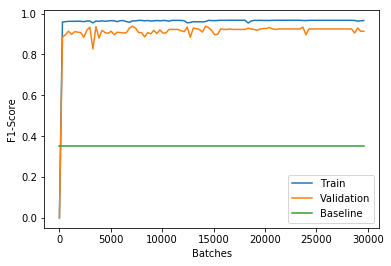

FInal Values: Tr-F1: 0.9662, Val-F1: 0.9139
Test F1-Score: 0.9338



In [8]:
NN = FF_Model(layers=[100], activ='sigmoid', dropout=1.0, learn_rate=0.01, decay=0.002)
NN.build_graph()
results_list = NN.train(sets, epochs=5, batch=50, report_percentage=1, show_plot=True, show_progress=True)

In [9]:
res = NN.predict(sets['test_set'])
tru = np.argmax(sets['test_labels'], 1)

In [10]:
tok_perf = fn.token_perf(res, tru)

TP	TN	FP	FN
127	11016	17	1

Precision: 0.8819
Recall: 0.9922
F1-Score: 0.9338


In [11]:
baseline = [0 if word in target_dict['medications'] else 1 for word in sets['test_words']]
sk.metrics.f1_score(np.argmax(sets['test_labels'], 1), baseline, pos_label=0, average='binary')

0.020043572984749455

In [12]:
fn.category_words(sets['test_words'], res, tru, 0, 1)

nasal, cannula, iv, nasal, cannula, each, subcutaneous, subcutaneous, iv, oral, po, intravenous, po, each, nasal, sprays, ou


In [13]:
fn.colour_text(sets['test_words'], res, tru)

record #<num> <num> | tmh | <num> | | <num> | <num>/<num>/<num> <num>:<num>:<num> am | discharge summary | signed | dis | admission date <num>/<num>/<num> report status signed discharge date <num>/<num>/<num> history ms pizzo is a <num>-year-old woman with peripheral vascular disease who recently underwent revision of her left superior femoral artery anterior tibial bypass graft , who now presents with a cool , ischemic left foot mrs denman is a <num>-year-old , insulin-dependent diabetic with a long history of peripheral vascular disease as well as multiple surgical procedures she underwent a right transmetatarsal amputation in <num> and subsequently underwent a right femorla distal saphenous vein bypass graft in <num> which was later revised in <num>. she seems to be doing well with the left side until july of this year , at which time she underwent a left superficial femoral artery to anterior tibial artery bypass using non-reversed basilic vein harvested from the right arm she , ho

In [14]:
testers = Dataset.get_DS(stage='train', labelled='yes')
_ = fn.phrase_perf(target, NN, testers, model, case_info=True, show_phrases=True)

Name:  0101
Challenge:  2009 Medication Challenge
Train or Test Set:  train
Labelled:  yes
Labeling Type:  train


subcu [35, 1] [35, 1] subcu [35, 1] [35, 1]
po [38, 0] [38, 0] p.o. [38, 0] [38, 0]
intravenous [52, 9] [52, 9] intravenous [52, 9] [52, 9]
iv [70, 5] [70, 5] iv [70, 5] [70, 5]
po [71, 1] [71, 1] p.o. [71, 1] [71, 1]
po [74, 5] [74, 5] p.o. [74, 5] [74, 5]
po [74, 13] [74, 13] p.o. [74, 13] [74, 13]
subcu [75, 6] [75, 6] subcu [75, 6] [75, 6]
subcu [76, 0] [76, 0] subcu [76, 0] [76, 0]
po [77, 5] [77, 5] p.o. [77, 5] [77, 5]


Name:  0102
Challenge:  2009 Medication Challenge
Train or Test Set:  train
Labelled:  yes
Labeling Type:  train


drip [78, 4] [78, 4] drip. [78, 4] [78, 4]
nasal cannula [84, 8] [84, 9]
intravenous [86, 0] [86, 0] intravenous [86, 0] [86, 0]
drip [86, 6] [86, 6] drip [86, 6] [86, 6]
iv [87, 4] [87, 4]
subq [101, 0] [101, 0] subq [101, 0] [101, 0]
subcutaneous [101, 6] [101, 6] subcutaneous [101, 6] [101, 6]
subcutaneous [103, 1] [103, 1] subcutane

# HyperParameter Scan

In [ ]:
emb_model = {'CBOW': 0}
layers = [100]
layer_num = [1]
activ = ['sigmoid']
dropouts = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]
learn_rates = [0.01]
epoch_nums = [5]
NN_num = 5

target_names = ['m', 'do', 'mo', 'f', 'du', 'r']

model_num = len(emb_model) * len(layers) * len(layer_num) * len(activ) * len(dropouts) * len(learn_rates) * len(epoch_nums) * NN_num * len(target_names)


print(model_num)

In [ ]:
#%%capture
n = 0
results = []
for i in range(len(target_names)):
    train_set.process_for_testing(target_names[i])
    validation_set.process_for_testing(target_names[i])
    test_set.process_for_testing(target_names[i])
    sets = {}
    sets['train_set'], sets['train_labels'], sets['train_words'] = train_set.get_ff_sets(model)
    sets['validation_set'], sets['validation_labels'], sets['validation_words'] = validation_set.get_ff_sets(model)
    sets['test_set'], sets['test_labels'], sets['test_words'] = test_set.get_ff_sets(model)
    fn.saturate_training_set(sets, 0.1)
    timestamp = re.sub(r':', '-', str(datetime.datetime.now()).split('.')[0])
    with open('tests/Model2/' + target_names[i] + '/' + timestamp, 'w+') as f:    
        print('Drop:\tVTF1:\tVPF1:\tTTF1:\tTPF1:')
        f.write(target_names[i] + '\n')
        f.write('Drop:\tVTF1:\tVPF1:\tTTF1:\tTPF1:\n')
        for drop in dropouts:
            bestvtf1 = 0
            bestvpf1 = 0
            bestttf1 = 0
            besttpf1 = 0
            NN = FF_Model(layers=[100], activ='sigmoid', dropout=drop, learn_rate=0.01, decay=0.002)
            NN.build_graph()
            for k in range(NN_num):
                n += 1
                print('Model Number: {}/{}'.format(n, model_num), end='\r')
                _, _, _, = NN.train(sets, epochs=5, batch=50)
                valpred = NN.predict(sets['validation_set'])
                if sum(valpred) == len(valpred):
                    valdict = {'f1': 0}
                    valdict2 = {'f1': 0}
                else:
                    valdict = fn.token_perf(res=valpred, tru=np.argmax(sets['validation_labels'], 1), tfpn=False, precision=False, recall=False, f1=False)
                    valdict2 = fn.phrase_perf(target_names[i], NN, validation_set, model, tfpn=False, precision=False, recall=False, f1=False)
                bestvtf1 = max(bestvtf1, valdict['f1'])
                bestvpf1 = max(bestvpf1, valdict2['f1'])
                testpred = NN.predict(sets['test_set'])
                if sum(testpred) == len(testpred): 
                    testdict = {'f1': 0}
                    testdict2 = {'f1': 0}
                else:
                    testdict = fn.token_perf(res=testpred, tru=np.argmax(sets['test_labels'], 1), tfpn=False, precision=False, recall=False, f1=False)
                    testdict2 = fn.phrase_perf(target_names[i], NN, test_set, model, tfpn=False, precision=False, recall=False, f1=False)
                bestttf1 = max(bestttf1, testdict['f1'])
                besttpf1 = max(besttpf1, testdict2['f1'])
                NN.close()
            results.append([bestvtf1, bestvpf1, bestttf1, besttpf1])
            print('{}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}'.format(drop, *results[-1]))
            f.write('{}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}\n'.format(drop, *results[-1]))

        #print('Max Performance: {:.4f}'.format(max(results)))  
        #f.write('Max Performance: {:.4f}\n'.format(max(results)))

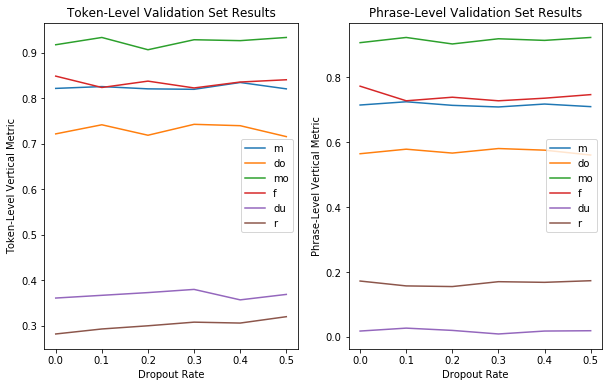

In [30]:
from matplotlib import pyplot as plt

points = np.array(range(6)) * 0.1

mt = [0.822, 0.826, 0.821, 0.820, 0.835, 0.821]
dot = [0.722, 0.742, 0.719, 0.743, 0.740, 0.716]
mot = [0.918, 0.934, 0.907, 0.929, 0.927, 0.934]
ft = [0.849, 0.824, 0.838, 0.823, 0.836, 0.841]
dut = [0.361, 0.367, 0.373, 0.380, 0.357, 0.369]
rt = [0.282, 0.293, 0.300, 0.308, 0.306, 0.320]

mp = [0.714, 0.724, 0.713, 0.708, 0.717, 0.709]
dop = [0.564, 0.578, 0.566, 0.580, 0.575, 0.560]
mop = [0.906, 0.922, 0.902, 0.918, 0.913, 0.922]
fp = [0.772, 0.727, 0.738, 0.727, 0.735, 0.746]
dup = [0.018, 0.027, 0.020, 0.009, 0.018, 0.019]
rp = [0.172, 0.157, 0.155, 0.170, 0.168, 0.173]

fig = plt.figure(figsize=(10, 6))
plt.subplots_adjust(hspace=0.4)

plt.subplot(121)
plt.plot(points, mt, label="m")
plt.plot(points, dot, label="do")
plt.plot(points, mot, label="mo")
plt.plot(points, ft, label="f")
plt.plot(points, dut, label="du")
plt.plot(points, rt, label="r")
plt.xlabel("Dropout Rate")
plt.ylabel("Token-Level Vertical Metric")
plt.title('Token-Level Validation Set Results')
plt.legend()

plt.subplot(122)
plt.plot(points, mp, label="m")
plt.plot(points, dop, label="do")
plt.plot(points, mop, label="mo")
plt.plot(points, fp, label="f")
plt.plot(points, dup, label="du")
plt.plot(points, rp, label="r")
plt.xlabel("Dropout Rate")
plt.ylabel("Phrase-Level Vertical Metric")
plt.title('Phrase-Level Validation Set Results')
plt.legend()

plt.show()